# Implementing and applying an Extended Kalman Filter (EKF) to estimate the 2D pose of the robot throughout its traversal using sensor measurements. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# To install numpy, use(the command inside quotes) - "pip install numpy"
# To install matplotlib, use(the command inside quotes) - "pip install matplotlib"

### Predicting Mean

In [4]:
def predict(Ut, Mt_1):
    dt = 0.1
    x1 = Mt_1[0][0]
    y1 = Mt_1[1][0]
    theta1 = Mt_1[2][0]
    
    vk = Ut[0][0]
    wk = Ut[1][0]
    
    mat1 = np.array([[x1], [y1], [theta1]])
    mat2 = np.array([[np.cos(theta1), 0], [np.sin(theta1), 0], [0, 1]])
    mat3 = np.array([[vk], [wk]])
    
    return mat1 + dt * mat2 @ mat3


### Computing Jacobian 'G' of the motion model g()

In [5]:
def jacobian(Ut, Mt):
    dt = 0.1
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]
    
    vk = Ut[0][0]
    wk = Ut[1][0]
    
    term1 = (-1) * vk * dt * np.sin(thetak)
    term2 = vk * dt * np.cos(thetak)
    
    G = [[1,0,term1], [0,1,term2], [0,0,1]]
    return np.array(G)



### Predicting Covariance

In [6]:
def predict_Sig(Sigt_1, Mt, Rt, Ut):
    Gt = jacobian(Ut, Mt)
    return Gt @ Sigt_1 @ Gt.T + Rt



### The prediction steps in the EKF Algorithm:

In [7]:
def prediction(Ut, Mt_1, Sigt_1, Rt):
    Mt = predict(Ut, Mt_1)
    Sigt = predict_Sig(Sigt_1, Mt, Rt, Ut)
    return Mt, Sigt

### Correction
    - Now we apply correction, that is, whether we trust our prediction or the sensor observation. 
    - We do so by computing the weighted mean between the two. 

In [8]:
def jacobian_2(Mt, landmark, d):
    xl = landmark[0][0]
    yl = landmark[1][0]
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]

    p = xl - xk - d * np.cos(thetak)
    q = yl - yk - d * np.sin(thetak)
    
    normpq = np.sqrt(p*p + q*q)
    pq = (p*p + q*q)
    
    val1 = -p / normpq
    val2 = -q / normpq
    val3 = (d / normpq) * (p * np.sin(thetak) - q * np.cos(thetak))
    val4 = q / pq
    val5 = -p / pq
    val6 = ( -d * (p * np.cos(thetak) + q * np.sin(thetak)) / pq ) - 1
    
    G = np.array([[val1, val2, val3], [val4, val5, val6]])
    return G

### Computing the Kalman Gain

In [9]:
def get_K(Sigt, Mt, landmark, Qt, d):
    Ht = jacobian_2(Mt, landmark, d) 
    K = Sigt @ Ht.T @ np.linalg.inv(Ht @ Sigt @ Ht.T + Qt)
    return K, Ht


### Correcting the Mu and Sigma values

After having calulated the Jacobian and Kalman Gain, we now apply the correction steps of the EKF algorithm.

- This function normalises the angles, that the laser rangefinder estimates for each landmark. 

In [1]:
def change_range(x):
    return (x + np.pi) % ( 2 * np.pi ) - np.pi

- This computes the distance and bearing to each landmark, in accordance with the non linear sensor model. 

In [11]:
def sensor_model(Mt, landmark, d, num):
    xl = landmark[0][0]
    yl = landmark[1][0]
    xk = Mt[0][0]
    yk = Mt[1][0]
    thetak = Mt[2][0]
    
    p = xl - xk - d * np.cos(thetak)
    q = yl - yk - d * np.sin(thetak)
        
    val1 = np.sqrt(p*p + q*q)
    val2 = np.arctan2(q, p) - thetak
    val2_modified = change_range(val2)
    
    
    return np.array([[val1], [val2_modified]])



 -   Applying correction to the mean. Mt is the mean we predicted after the first step of the algorithm.
 -   Now depending on value of Kalman Gain, we compute the corrected mean.



In [12]:
def update(Mt, Kt, Zt, landmark, d):
    h_M = sensor_model(Mt, landmark, d, Zt[1])
    M = Mt + Kt @ (Zt - h_M)
    return M

 - this function applies correction to the covariance 'sigma'

In [13]:
def update_sig(Sigt, Kt, Ht):
    I = np.eye(3)
    S = (I - (Kt @ Ht)) @ Sigt
    return S

### Correction steps in the EKF algorithm
- This function calls the appropriate functions, thereby implementing the next 3 steps of the EKF algorithm, after prediction

In [14]:
def correction(Sigt, Mt, landmark, Qt, Zt, d):
    Kt, Ht = get_K(Sigt, Mt, landmark, Qt, d)
    Mt = update(Mt, Kt, Zt, landmark, d)
    Sigt = update_sig(Sigt, Kt, Ht)
    return Kt, Ht, Mt, Sigt



### Loading the data

In [15]:
dataset = np.load('dataset.npz')

In [16]:
M0 = np.array([[dataset['x_true'][0][0]], [dataset['y_true'][0][0]], [dataset['th_true'][0][0]]])
Sig0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.1]])


In [17]:
Rt = np.array([[dataset['v_var'][0][0], 0, 0], [0, dataset['v_var'][0][0], 0], [0, 0, dataset['om_var'][0][0]]])
Qt = np.array([[dataset['r_var'][0][0], 0], [0, dataset['b_var'][0][0]]])


In [18]:
r = dataset['r'] 
b = dataset['b'] 
Uv = dataset['v']
Uom = dataset['om']

In [19]:
landmarks = dataset['l']

U = []
for i in range(len(dataset['v'])):
    U.append(np.array( [ [Uv[i][0]], [Uom[i][0]] ] ))
U = np.array(U)

time_stamps = len(dataset['t'])
d = dataset['d'][0][0]

Mt = []
Sigt = []
Mt.append(M0)
Sigt.append(Sig0)


### Running the EKF algorithm

In [20]:
for i in range(time_stamps):
   
    Mt_new, Sigt_new = prediction(U[i], Mt[i], Sigt[i], Rt)

    for index, landmark in enumerate(landmarks):
        Zt = np.array( [ [r[i][index]], [b[i][index]] ] )
        lm = np.array( [ [landmark[0]], [landmark[1]] ] )
        if(Zt[0] == 0):
            continue

        Kt_c, Ht_c, Mt_new, Sigt_new = correction(Sigt_new, Mt_new, lm, Qt, Zt, d)
    
    Mt.append(Mt_new)
    Sigt.append(Sigt_new)


### Plotting the predicted path 

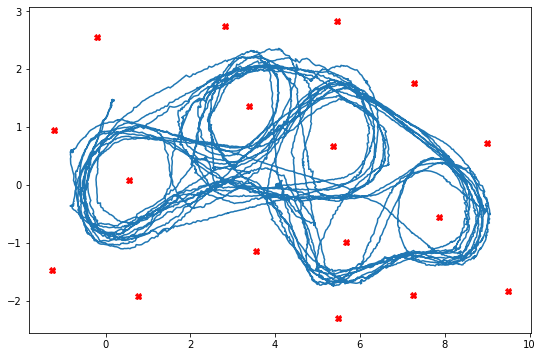

In [22]:
x = []
y = []

for m in np.array(Mt):
    x.append(m[0][0])
    y.append(m[1][0])

plt.figure(figsize = (9,6))
plt.plot(landmarks[:,0], landmarks[:,1], 'rX')
plt.plot(x, y)

### Ground Truth Trajectory

In [25]:
def plot():
    plt.figure(figsize = (9,6))
    plt.plot(X_ground, Y_ground, color='magenta', label="groundtruth")
    plt.plot(x,y,color ='cyan', label = "EKF-estimate")
    plt.plot(landmarks[:,0], landmarks[:,1], 'rX', label = "landmark")
    plt.legend()
    plt.show()
    


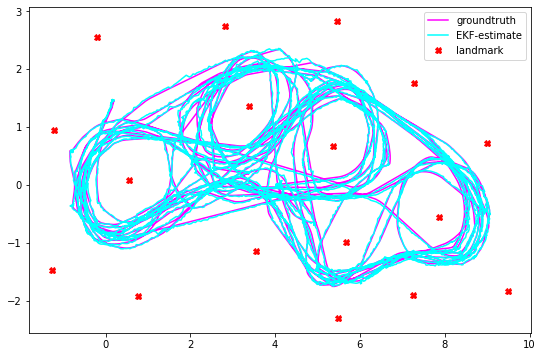

In [26]:
X_ground = dataset['x_true']
Y_ground = dataset['y_true']
plot()